## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/3.98M [00:00<?, ?B/s]
100% 3.98M/3.98M [00:00<00:00, 65.3MB/s]
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## LightGBMによる回帰

In [ ]:
!pip install japanize-matplotlib

None
     |████████████████████████████████| 4.1 MB 5.0 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=4138c0fb4b29eaa1034587c92b4e0e13e9f4c1cdb24ae2bd4a7958f331ab48b2
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [ ]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import japanize_matplotlib

import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1).select_dtypes(include="number"), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

## LGMBRegressor

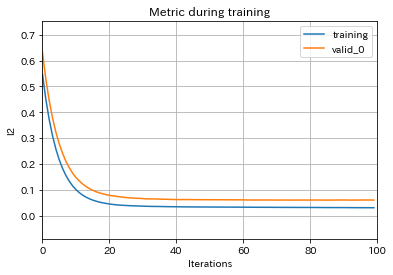

In [ ]:
model = lgb.LGBMRegressor(
    random_state = SEED,
)

model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test), (X_train, y_train)],
    verbose=-1 # 学習ログを省略
)

# 損失の表示
lgb.plot_metric(model)

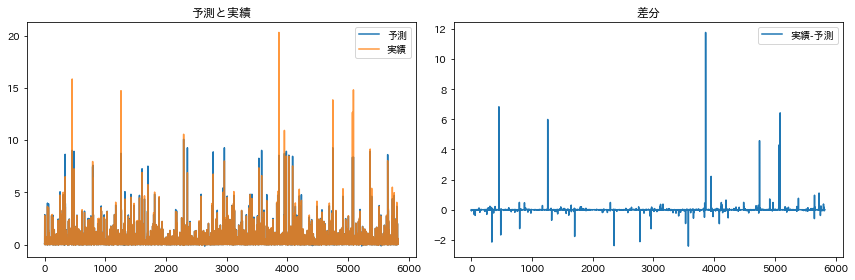

In [ ]:
fig = plt.figure(figsize=(12,  4))

plt.subplot(1, 2, 1)
plt.title("予測と実績")
plt.plot(model.predict(X_test), label="予測")
plt.plot(y_test.reset_index(drop=True), label="実績", alpha=0.8)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("差分")
plt.plot(y_test.reset_index(drop=True) - model.predict(X_test), label="実績-予測")
plt.legend()

plt.tight_layout()
plt.show()

## LightGBM param regression

In [ ]:
# データセットを登録
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [ ]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',  # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          }

In [ ]:
lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,             # 学習の履歴を保存
                  verbose_eval=-1                           # ログを最後の1つだけ表示
                  )  

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174516	Test's rmse: 0.245209


### 損失の表示

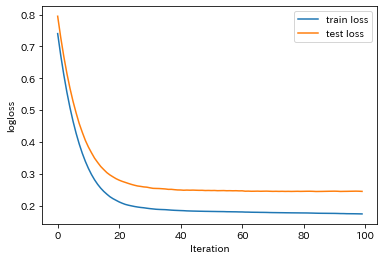

In [ ]:
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

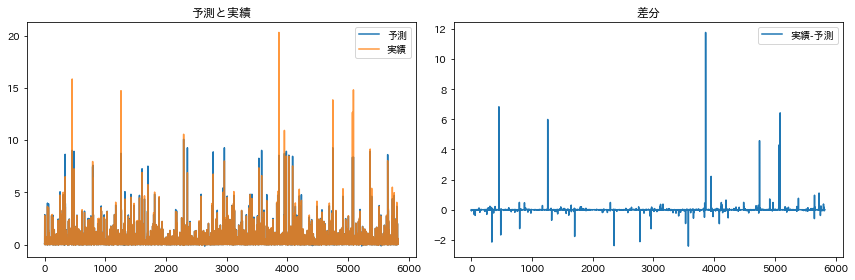

In [ ]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title("予測と実績")
plt.plot(model.predict(X_test), label="予測")
plt.plot(y_test.reset_index(drop=True), label="実績", alpha=0.8)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("差分")
plt.plot(y_test.reset_index(drop=True) - model.predict(X_test), label="実績-予測")
plt.legend()

plt.tight_layout()
plt.show()

### カスタムメトリクス

In [ ]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': "None",  # 回帰の損失に None を指定
          'learning_rate': 0.1,         # 学習率
          }

In [ ]:
def custom_metrics(y_pred, data):

    y_true = data.get_label() # lgb.Dataset() から 目的変数を取得

    score = np.mean( np.sqrt( (y_true - y_pred) / y_true) ** 2 ) # 評価結果を算定。平均処理を行う

    return 'custom_metrics', score, False

In [ ]:
lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,             # 学習の履歴を保存
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  feval=custom_metrics,
                  )  

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[36]	Train's custom_metrics: 0.0170729	Test's custom_metrics: 0.017991


### 損失の表示

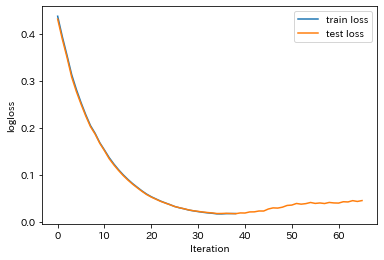

In [ ]:
loss_train = lgb_results['Train']['custom_metrics']
loss_test = lgb_results['Test']['custom_metrics']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

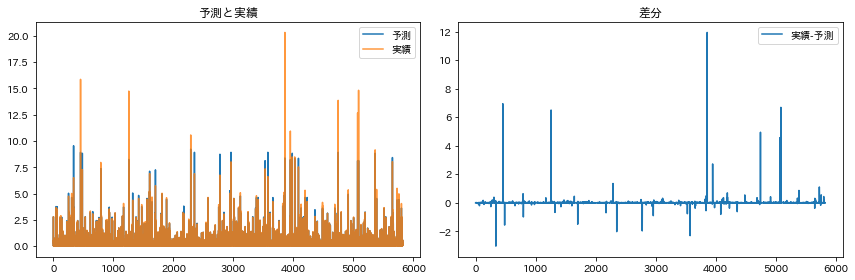

In [ ]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title("予測と実績")
plt.plot(model.predict(X_test), label="予測")
plt.plot(y_test.reset_index(drop=True), label="実績", alpha=0.8)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("差分")
plt.plot(y_test.reset_index(drop=True) - model.predict(X_test), label="実績-予測")
plt.legend()

plt.tight_layout()
plt.show()